In [1]:
from music21 import *

In [15]:
def read_midi(file):
    
    print("LOADING MUSIC FILE : ",file)
    
    notes = []
    notes_to_parsed = None
    
    #parsing a midi file
    midi = converter.parse(file)
    
    #Grouping based on different instruments
    s2 = instrument.partitionByInstrument(midi)
    
    #Looping over all the instruments
    if s2:
        for part in s2.parts:

            #Select elements of Piano

            if 'Piano' in str(part):
                notes_to_parse = part.recurse()


                #Finding whether a particular element is a note or a chord

                for element in notes_to_parse:

                    #Note
                    if isinstance(element, note.Note):
                        notes.append(str(element.pitch))

                    elif isinstance(element, chord.Chord):
                        notes.append('.'.join(str(n) for n in element.normalOrder))
    else:
        pass
    return np.array(notes)

In [16]:
import os 

import numpy as np

path = 'D:/MusicGeneration/MusicData/'


#Read all the file names
files = [i for i in os.listdir(path) if i.endswith('.mid')]

#Reading each midi file
notes_array = np.array([read_midi(path+i) for i in files])

LOADING MUSIC FILE :  D:/MusicGeneration/MusicData/A-Whole-New-World-(Theme-From-'Aladdin').mid
LOADING MUSIC FILE :  D:/MusicGeneration/MusicData/Backstreet Boys - I Want It That Way.mid
LOADING MUSIC FILE :  D:/MusicGeneration/MusicData/Coldplay - Viva La Vida.mid
LOADING MUSIC FILE :  D:/MusicGeneration/MusicData/darude-sandstorm.mid
LOADING MUSIC FILE :  D:/MusicGeneration/MusicData/Linkin Park - Numb (Tim Dawes Remix).mid
LOADING MUSIC FILE :  D:/MusicGeneration/MusicData/Michael Jackson - Beat It.mid
LOADING MUSIC FILE :  D:/MusicGeneration/MusicData/Michael Jackson - Billie Jean.mid
LOADING MUSIC FILE :  D:/MusicGeneration/MusicData/My-Heart-Will-Go-On-(From-'Titanic').mid
LOADING MUSIC FILE :  D:/MusicGeneration/MusicData/Naruto - Naruto Main Theme-Short Version.mid
LOADING MUSIC FILE :  D:/MusicGeneration/MusicData/Naruto Shippuden - Naruto Shpippuuden Opening 9 (1).mid
LOADING MUSIC FILE :  D:/MusicGeneration/MusicData/Naruto Shippuden - Naruto Shpippuuden Opening 9.mid
LOADI

In [17]:
#Converting 2D array into an 1D array
notes_ = [element for note_ in notes_array for element in note_]

#No. of unique notes
unique_notes = list(set(notes_))
print(len(unique_notes))

350


(array([231.,  33.,  31.,  11.,   8.,   9.,   6.,  11.,   6.,   4.]),
 array([1.0000e+00, 1.6170e+02, 3.2240e+02, 4.8310e+02, 6.4380e+02,
        8.0450e+02, 9.6520e+02, 1.1259e+03, 1.2866e+03, 1.4473e+03,
        1.6080e+03]),
 <a list of 10 Patch objects>)

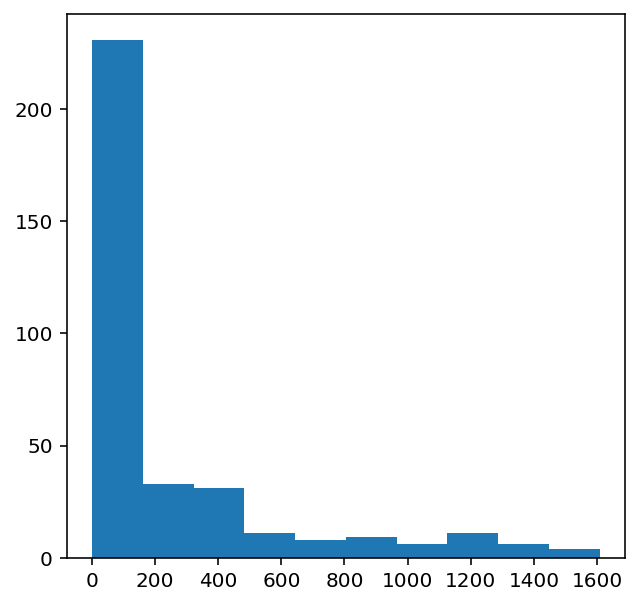

In [18]:
#Distribution of Notes
#importing library
from collections import Counter

#computing frequency of each note
freq = dict(Counter(notes_))

#library for visualiation
import matplotlib.pyplot as plt

#consider only the frequencies
no=[count for _,count in freq.items()]

#set the figure size
plt.figure(figsize=(5,5))

#plot
plt.hist(no)

In [19]:
frequent_notes = [note_ for note_, count in freq.items() if count>=50]
print(len(frequent_notes))

179


In [20]:
"""
As you can see here, no. of frequently occurring notes is around 170. 
Now, let us prepare new musical files which contain only the top frequent notes
"""
new_music=[]

for notes in notes_array:
    temp=[]
    for note_ in notes:
        if note_ in frequent_notes:
            temp.append(note_)            
    new_music.append(temp)
    
new_music = np.array(new_music)

In [21]:
"""
Preparing the input and output sequences as mentioned in the article:
"""
no_of_timesteps = 32
x = []
y = []

for note_ in new_music:
    for i in range(0, len(note_) - no_of_timesteps, 1):
        
        #preparing input and output sequences
        input_ = note_[i:i + no_of_timesteps]
        output = note_[i + no_of_timesteps]
        
        x.append(input_)
        y.append(output)
        
x=np.array(x)
y=np.array(y)

In [22]:
unique_x = list(set(x.ravel()))
x_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_x))

In [23]:
#preparing input sequences
x_seq=[]
for i in x:
    temp=[]
    for j in i:
        #assigning unique integer to every note
        temp.append(x_note_to_int[j])
    x_seq.append(temp)
    
x_seq = np.array(x_seq)

In [24]:
unique_y = list(set(y))
y_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_y)) 
y_seq=np.array([y_note_to_int[i] for i in y])

In [25]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(x_seq,y_seq,test_size=0.2,random_state=0)

In [27]:
from keras.layers import *
from keras.models import *
from keras.callbacks import *
import keras.backend as K

K.clear_session()
model = Sequential()
    
#embedding layer
model.add(Embedding(len(unique_x), 100, input_length=32,trainable=True)) 

model.add(Conv1D(64,3, padding='causal',activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))
    
model.add(Conv1D(128,3,activation='relu',dilation_rate=2,padding='causal'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))

model.add(Conv1D(256,3,activation='relu',dilation_rate=4,padding='causal'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))
          
#model.add(Conv1D(256,5,activation='relu'))    
model.add(GlobalMaxPool1D())
    
model.add(Dense(256, activation='relu'))
model.add(Dense(len(unique_y), activation='softmax'))
    
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 32, 100)           17900     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 32, 64)            19264     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 64)            0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 16, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 16, 128)           24704     
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 128)           0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 8, 128)           

In [28]:
mc=ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True,verbose=1)

In [29]:
history = model.fit(np.array(x_tr),np.array(y_tr),batch_size=128,epochs=50, validation_data=(np.array(x_val),np.array(y_val)),verbose=1, callbacks=[mc])

C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 62784 samples, validate on 15696 samples
Epoch 1/50
62784/62784 [==============================] - 10s 161us/step - loss: 4.2019 - val_loss: 3.8984

Epoch 00001: val_loss improved from inf to 3.89839, saving model to best_model.h5
Epoch 2/50
62784/62784 [==============================] - 6s 90us/step - loss: 3.6652 - val_loss: 3.6989

Epoch 00002: val_loss improved from 3.89839 to 3.69891, saving model to best_model.h5
Epoch 3/50
62784/62784 [==============================] - 6s 91us/step - loss: 3.4975 - val_loss: 3.5938

Epoch 00003: val_loss improved from 3.69891 to 3.59381, saving model to best_model.h5
Epoch 4/50
62784/62784 [==============================] - 6s 90us/step - loss: 3.3834 - val_loss: 3.5088

Epoch 00004: val_loss improved from 3.59381 to 3.50879, saving model to best_model.h5
Epoch 5/50
62784/62784 [==============================] - 6s 91us/step - loss: 3.2838 - val_loss: 3.4130

Epoch 00005: val_loss improved from 3.50879 to 3.41303, saving model to best_m

62784/62784 [==============================] - 6s 90us/step - loss: 2.3727 - val_loss: 2.7742

Epoch 00045: val_loss did not improve from 2.77095
Epoch 46/50
62784/62784 [==============================] - 6s 90us/step - loss: 2.3758 - val_loss: 2.7685

Epoch 00046: val_loss improved from 2.77095 to 2.76845, saving model to best_model.h5
Epoch 47/50
62784/62784 [==============================] - 6s 90us/step - loss: 2.3657 - val_loss: 2.7489

Epoch 00047: val_loss improved from 2.76845 to 2.74893, saving model to best_model.h5
Epoch 48/50
62784/62784 [==============================] - 6s 91us/step - loss: 2.3640 - val_loss: 2.7422

Epoch 00048: val_loss improved from 2.74893 to 2.74217, saving model to best_model.h5
Epoch 49/50
62784/62784 [==============================] - 6s 91us/step - loss: 2.3542 - val_loss: 2.7422

Epoch 00049: val_loss did not improve from 2.74217
Epoch 50/50
62784/62784 [==============================] - 6s 91us/step - loss: 2.3514 - val_loss: 2.7504

Epoch 0005

In [30]:
#loading best model
from keras.models import load_model
model = load_model('best_model.h5')

C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [31]:

import random
ind = np.random.randint(0,len(x_val)-1)

random_music = x_val[ind]

predictions=[]
for i in range(10):

    random_music = random_music.reshape(1,no_of_timesteps)

    prob  = model.predict(random_music)[0]
    y_pred= np.argmax(prob,axis=0)
    predictions.append(y_pred)

    random_music = np.insert(random_music[0],len(random_music[0]),y_pred)
    random_music = random_music[1:]
    
print(predictions)

[52, 92, 92, 92, 92, 92, 154, 28, 154, 154]


In [32]:
x_int_to_note = dict((number, note_) for number, note_ in enumerate(unique_x)) 
predicted_notes = [x_int_to_note[i] for i in predictions]

In [33]:
def convert_to_midi(prediction_output):
   
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                
                cn=int(current_note)
                new_note = note.Note(cn)
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
                
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
            
        # pattern is a note
        else:
            
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 1
    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp='music.mid')

In [34]:
convert_to_midi(predicted_notes)